<a href="https://colab.research.google.com/github/cryptowhaler/Sigh_Finance/blob/master/tree/master/Harvests/Compound_Interest_Yields.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **COMPOUND FINANCE:** SIMULATING INTEREST RATE MODELS

This Notebook describes and simulates the Interest Rate Model of **Compound Finance** while comparing it with another PID based Interest Rate Model.

Compound Finance currently holds \$1.55 B TVL.

**NOTE :** The purpose of this study is to extend our learnings and conceptualize the interest rate model and \$SIGH Farming framework, the parameters for which will be defined and regulated by these data driven simulated A.I Models.

In [1]:
import math
import random

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# GLOBAL VARIABLES

BLOCKS_PER_YEAR = 6669

# **SIMULATED AGENTS**

We use 2 trading Agents to simulate the behaviour, which are briefly described below.

1. **Commercial Trader Agent :** 

*   A simulated trader who has an opinion on the fair market interest rate to lend or borrow, and will open positions when the market-offered interest rate is favourable to them.
*   The agent's equilibrium rate (their "opinion" on what the fair market interest rate should be) is given by a normal random walk with a drift towards the market-offered borrow rate at each timestep. This ensures there is a dispersion of opinions around some volatile consensus interest rate.
*   Each agent's bankroll (total borrowing or lending power) is drawn from a PARETO Distribution. The % of their bankroll which they borrow or lend is based on ***tanh*** biased. by their internal equilibrium rate.


2. **NOISE TRADING AGENT :**

*   This agent is meant to simulate a less-informed trader, or a large trader who is trying to get in and out of positions quickly without slippage.
*   Like the commercial trader, this trader's bankroll is sampled from a PARETO distribution.  
*   Each time-step, the agent has a chance to sample a new target position from a uniform distribution between -1 and 1 times its bankroll. 


**PARETO DISTRIBUTION :** The Pareto distribution governs the distribution of creative production across all creative domains. 

--> It is a probability distribution that is based on the observation that across almost all the domains, including wealth,usually a small percentage of people produce almost all the output. 

--> Pareto Distribution was originally applied to describing the distribution of wealth in a society, fitting the trend that a large portion of wealth is held by a small fraction of the population. 

--> The Pareto principle is also referred to as the "80-20 rule", stating that 80% of outcomes are due to 20% of causes. 

---


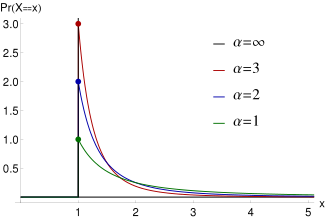
---

**PRICE's LAW :** Price's law was formulated during the study of overall scientific productivity where it was observed that a very small proportion of the scientists within a given scientific domain produced half the output.

Mathematically, it says that for a job with n workers, 50% of the work will be done by the square root of the total number of workers, or sqrt(n). As the number of workers increases, the proportion doing 50% of the work will decrease - sqrt(n)/n. 

There will be only one value of n at which the Pareto principle will agree with Price's Law.


In [3]:
# values = []
# for i in range(100) :
#   x = np.random.pareto(4) * 10000
#   values.append(x)

# print(values)

In [4]:
# values.sort()
# plt.plot(values)
# plt.title('PARETO DISTRIBUTION')
# plt.show()

In [5]:
math.tanh(0.01  * 35 * (-1))

-0.3363755443363322

In [6]:
np.random.normal(100) / 6500
# values = []
# for i in range(10000) :
#   x = np.random.normal(100)
#   values.append(x)

# # values.sort()
# plt.plot(values)
# plt.title('NORMAL DISTRIBUTION')
# plt.show()

0.01540367353616495

In [3]:
# CLASS : DEFINES A COMMERCIAL TRADING AGENT

# CONSTANTS
NUM_COMMERCIAL_TRADERS = 100 # the number of commercial traders in the simulation
COMMERCIAL_TRADER_INITIAL_EQUILIBRIUM_RATE = 0.05 # what each commercial trader's equilibrium rate starts at
COMMERCIAL_TRADER_PARETO_SHAPE = 3 # higher = more fat-tailed
COMMERCIAL_TRADER_MODE_BANKROLL = 10000 # the mode bankroll of a commercial trader, from a Pareto distribution
COMMERCIAL_TRADER_INTERNAL_VOLATILITY = 100 # annualized volatility of the equilibrium rate
COMMERCIAL_TRADER_REGULARIZATION_RATE = 0.9 # how much their equlibrium rate "decays" to the market-offered borrow rate per year
COMMERCIAL_TRADER_RISK_AVERSION = 25 # scaling factor of the tanh (trader requires a larger buffer in their favor to take a position)

class CommercialTrader:

  def __init__(self):
    # We assume that the account balances among the traders follow PARETO Distribution
    self.bankroll = (np.random.pareto(COMMERCIAL_TRADER_PARETO_SHAPE)) * COMMERCIAL_TRADER_MODE_BANKROLL
    self.equilibrium_rate = COMMERCIAL_TRADER_INITIAL_EQUILIBRIUM_RATE
    self.position = 0 # positive means supplying, negative means borrowing

  def _get_target_position(self):
    borrow_interest_rate = get_borrow_interest_rate()
    supply_interest_rate = get_supply_interest_rate()

    borrow_advantage = self.equilibrium_rate - borrow_interest_rate
    supply_advantage = supply_interest_rate - self.equilibrium_rate

    # If borrow rate is less than the trader's equilibrium rate, then the target position is -ve
    # representing that the trader will enter a borrow position
    if borrow_advantage >= supply_advantage and borrow_advantage > 0:
      return self.bankroll * math.tanh((borrow_interest_rate - self.equilibrium_rate) * COMMERCIAL_TRADER_RISK_AVERSION)
    # If supply rate is more than the trader's equilibrium rate, then the target position is +ve
    # representing that the trader will provide liquidity to the protocol
    elif supply_advantage >= borrow_advantage and supply_advantage > 0:
      return self.bankroll * math.tanh((supply_interest_rate - self.equilibrium_rate) * COMMERCIAL_TRADER_RISK_AVERSION)
    else:
      return 0

  # AGENT SUPPLIES LIQUIDITY (DEPOSIT)
  def _supply(self, supply_amount):
    global lent_currency

    self.position += supply_amount
    lent_currency += supply_amount

  # AGENT WITHDRAWS LIQUIDITY (REDEEM)
  def _withdraw(self, withdrawal_amount):
    global lent_currency

    actual_withdrawal_amount = min(withdrawal_amount, get_liquidity())
    self.position -= actual_withdrawal_amount
    lent_currency -= actual_withdrawal_amount

    return actual_withdrawal_amount == withdrawal_amount

  # AGENT TAKES A LOAN (BORROW)
  def _borrow(self, borrow_amount):
    global borrowed_currency

    actual_borrow_amount = min(borrow_amount, get_liquidity())
    self.position -= actual_borrow_amount
    borrowed_currency += actual_borrow_amount

    return actual_borrow_amount == borrow_amount

  # AGENT REPAYS THE LOAN (REPAY)
  def _repay(self, repay_amount):
    global borrowed_currency

    self.position += repay_amount
    borrowed_currency -= repay_amount

  #SIMMLATES TRADING BEHAVIOUR : AGENT TRIES TO ACHIEVE ITS TARGET POSITION
  def step(self):
    # equilibrium rate keeps drifting towards the market provided rates
    equilibrium_rate_displacement = np.random.normal(scale=COMMERCIAL_TRADER_INTERNAL_VOLATILITY) / BLOCKS_PER_YEAR
    self.equilibrium_rate *= (1 + equilibrium_rate_displacement)
    self.equilibrium_rate -= (self.equilibrium_rate - get_borrow_interest_rate()) * COMMERCIAL_TRADER_REGULARIZATION_RATE / BLOCKS_PER_YEAR

    target_position = self._get_target_position()

    if self.position >= 0 and target_position >= 0:
      position_difference = target_position - self.position
      if position_difference > 0:
        self._supply(position_difference)
      else:
        self._withdraw(-position_difference)
    elif self.position < 0 and target_position < 0:
      position_difference = target_position - self.position
      if position_difference < 0:
        self._borrow(-position_difference)
      else:
        self._repay(position_difference)
    elif self.position >= 0 and target_position < 0:
      if self._withdraw(self.position):
        self._borrow(-target_position)
    elif self.position < 0 and target_position >= 0:
      if self._repay(-self.position):
        self._supply(target_position)

Noise traders simulate the less informed traders.

For this simulation, we assume that they change their positions on average 4 times per year, and their target positions are choosen at random. 

In [4]:
# CLASS : DEFINES A NOISE TRADING AGENT

# CONSTANTS
NUM_NOISE_TRADERS = 50 # the number of noise traders in the simulation
NOISE_TRADER_PARETO_SHAPE = 3 # higher = more fat-tailed
NOISE_TRADER_MODE_BANKROLL = 25000 # the mode bankroll of a noise trader, from a Pareto distribution
NOISE_TRADER_RESAMPLING_RATE = 4 # average number of times per year a noise trader changes their position

class NoiseTrader:
  def __init__(self):
    self.bankroll = np.random.pareto(NOISE_TRADER_PARETO_SHAPE) * NOISE_TRADER_MODE_BANKROLL
    self.position = 0 # positive means supplying, negative means borrowing
    self.target_position = 0

  # AGENT SUPPLIES LIQUIDITY (DEPOSIT)
  def _supply(self, supply_amount):
    global lent_currency

    self.position += supply_amount
    lent_currency += supply_amount

  # AGENT WITHDRAWS LIQUIDITY (REDEEM)
  def _withdraw(self, withdrawal_amount):
    global lent_currency

    actual_withdrawal_amount = min(withdrawal_amount, get_liquidity())
    self.position -= actual_withdrawal_amount
    lent_currency -= actual_withdrawal_amount

    return actual_withdrawal_amount == withdrawal_amount

  # AGENT TAKES A LOAN (BORROW)
  def _borrow(self, borrow_amount):
    global borrowed_currency

    actual_borrow_amount = min(borrow_amount, get_liquidity())
    self.position -= actual_borrow_amount
    borrowed_currency += actual_borrow_amount

    return actual_borrow_amount == borrow_amount

  # AGENT REPAYS THE LOAN (REPAY)
  def _repay(self, repay_amount):
    global borrowed_currency

    self.position += repay_amount
    borrowed_currency -= repay_amount

  #SIMLATES TRADING BEHAVIOUR : AGENT TIRES TO ACHIEVE ITS TARGET POSITION BASED ON RESAMPLING RATE
  def step(self):
    chance_to_resample = NOISE_TRADER_RESAMPLING_RATE / BLOCKS_PER_YEAR
    if random.random() < chance_to_resample:
      self.target_position = self.bankroll * np.random.uniform(low=-1.0, high=1.0)

    target_position = self.target_position

    if self.position >= 0 and target_position >= 0:
      position_difference = target_position - self.position
      if position_difference > 0:
        self._supply(position_difference)
      else:
        self._withdraw(-position_difference)
    elif self.position < 0 and target_position < 0:
      position_difference = target_position - self.position
      if position_difference < 0:
        self._borrow(-position_difference)
      else:
        self._repay(position_difference)
    elif self.position >= 0 and target_position < 0:
      if self._withdraw(self.position):
        self._borrow(-target_position)
    elif self.position < 0 and target_position >= 0:
      if self._repay(-self.position):
        self._supply(target_position)

##**COMPOUND FINANCE:** INTEREST RATE MODEL

> **CONSTANTS**





In [5]:
# COMPOUND FINANCE

Compound_RESERVE_FACTOR = 0.1 # percent of interest paid by borrowers reserved by the protocol (same for both IRMs)

Compound_JUMP_IRM_BASE_BORROW_RATE = 0 # Annualized Borrow Rate : 0 % Utilization
Compound_JUMP_IRM_BORROW_RATE_MULTIPLIER = 0.05 # Annualized Borrow Rate : 100 % Utilization - kink
Compound_JUMP_IRM_KINK_UTILIZATION_RATE = 0.8 # utilization rate at which slope of borrow rate increases
Compound_JUMP_IRM_KINK_BORROW_RATE_MULTIPLIER = 1 # additional borrow rate multiplier after the kink

> **GETTER FUNCTIONS TO GET CURRENT SUPPLY / BORROW APY**



In [6]:
# BORROWING INTEREST RATES 
def get_COMPOUND_borrow_interest_rate_jump_irm():
  utilization_rate = get_utilization_rate()

  if utilization_rate == 0:
    return 0

  normal_borrow_rate = utilization_rate * Compound_JUMP_IRM_BORROW_RATE_MULTIPLIER + Compound_JUMP_IRM_BASE_BORROW_RATE

  if utilization_rate < Compound_JUMP_IRM_KINK_UTILIZATION_RATE:
    return normal_borrow_rate
  else:
    excess_utilization = utilization_rate - Compound_JUMP_IRM_KINK_UTILIZATION_RATE
    return normal_borrow_rate + (excess_utilization * Compound_JUMP_IRM_KINK_BORROW_RATE_MULTIPLIER)

# SUPPLIERS INTEREST RATES 
def get_COMPOUND_supply_interest_rate_jump_irm():
  if borrowed_currency == 0:
    return 0.05 # "unstick model at simulation start"
  
  return get_COMPOUND_borrow_interest_rate_jump_irm() * (1 - Compound_RESERVE_FACTOR) * get_utilization_rate()



##**PID:** INTEREST RATE MODEL

> **CONSTANTS**



In [63]:
# we use the "kink" as it allows the model to instantly respond
# to borrow saturation. This also serves as the "P" in the PID controller

PID_RESERVE_FACTOR = 0.1 # percent of interest paid by borrowers reserved by the protocol (same for both IRMs)

PID_PID_IRM_TARGET_UTILIZATION_RATE = 0.8 # what utilization rate the PID controller is trying to achieve
PID_PID_IRM_KINK_UTILIZATION_RATE = 0
PID_PID_IRM_KINK_BORROW_RATE_MULTIPLIER = 0.1
PID_PID_IRM_INTEGRAL_GAIN = 0.02 # how quickly the PID IRM will decrease borrow interest rates when utilization rate is below target and vice versa
PID_PID_IRM_DERIVATIVE_GAIN = 100 # how aggressively the PID IRM inversely corrects interest rates to avoid overshooting

**GETTERS**

In [64]:
# GETTER FUNCTIONS FOR "SIGH FINANCE [ IN DEVELOPMENT / SIMULATION PHASE ]"

# PROPORTIONAL SIGNAL PID-IRM
def get_PID_proportional_signal_pid_irm():
  utilization_rate = get_utilization_rate()
  proportional_signal = 0

  if utilization_rate > PID_PID_IRM_KINK_UTILIZATION_RATE:
    excess_utilization = utilization_rate - PID_PID_IRM_KINK_UTILIZATION_RATE
    proportional_signal = excess_utilization * PID_PID_IRM_KINK_BORROW_RATE_MULTIPLIER

  return proportional_signal

# BORROWING INTEREST RATES 
def get_PID_borrow_interest_rate_pid_irm():
  global pid_derivative_signal, pid_integral_accumulator, pid_last_evaluated_block, pid_last_evaluated_utilization_rate, block_number

  utilization_rate = get_utilization_rate()

  if utilization_rate == 0:
    return 0

  proportional_signal = get_PID_proportional_signal_pid_irm()

  pid_integral_accumulator += (utilization_rate - PID_PID_IRM_TARGET_UTILIZATION_RATE) / BLOCKS_PER_YEAR
  integral_signal = pid_integral_accumulator * PID_PID_IRM_INTEGRAL_GAIN

  if pid_last_evaluated_block != block_number:
    block_difference = block_number - pid_last_evaluated_block
    pid_derivative_signal = (utilization_rate - pid_last_evaluated_utilization_rate) / (BLOCKS_PER_YEAR / block_difference) * PID_PID_IRM_DERIVATIVE_GAIN

  pid_last_evaluated_block = block_number
  pid_last_evaluated_utilization_rate = utilization_rate

  return max(0, proportional_signal + integral_signal + pid_derivative_signal)

# SUPPLIERS INTEREST RATES 
def get_PID_supply_interest_rate_pid_irm():
  if borrowed_currency == 0:
    return 0.05 # "unstick model at simulation start"
  
  return get_PID_borrow_interest_rate_pid_irm() * (1 - PID_RESERVE_FACTOR) * get_utilization_rate()



## **GETTERS COMMON ACROSS IRMs**



In [7]:
# GETS UTILIZATION RATE
def get_utilization_rate():
  if lent_currency == 0:
    return 0

  return borrowed_currency / lent_currency

# CURRENT AVAILABLE LIQUIDITY
def get_liquidity():
  return lent_currency - borrowed_currency

# GET BORROWER INTEREST RATES 
def get_borrow_interest_rate():
  if interest_rate_model_in_use == 'compound':
    return get_COMPOUND_borrow_interest_rate_jump_irm()
  if interest_rate_model_in_use == 'pid':
    return get_PID_borrow_interest_rate_pid_irm()

# GET SUPPLIER INTEREST RATES 
def get_supply_interest_rate():
  if interest_rate_model_in_use == 'compound':
    return get_COMPOUND_supply_interest_rate_jump_irm()
  if interest_rate_model_in_use == 'pid':
    return get_PID_supply_interest_rate_pid_irm()

##**COMPOUND FINANCE** : SIMULATED PERFORMANCE

> **INITIAL STATE**



In [101]:
interest_rate_model_in_use = 'compound'

block_number = 0
SIMULATION_LENGTH_YEARS = 4
agents = []

# INITIAL BALANCE
lent_currency = 0
borrowed_currency = 0

# VARIABLES WHICH STORE HISTORICAL LIQUIDITY / BORROWING BALANCES AND INTEREST RATES
lent_currency_history = []
borrowed_currency_history = []
borrow_interest_rate_history = []
supply_interest_rate_history = []
mean_equilibrium_interest_rate_history = []
stdev_equilibrium_interest_rate_history = []
utilization_rate_history = []
interest_paid_history = []
spreadBetweenInterestRatesHistory = []

In [102]:
#INITIALIZING COMMERCIAL TRADERS
for i in range(NUM_COMMERCIAL_TRADERS):
  agents.append(CommercialTrader())

#INITIALIZING NOISE TRADERS
for i in range(NUM_NOISE_TRADERS):
  agents.append(NoiseTrader())

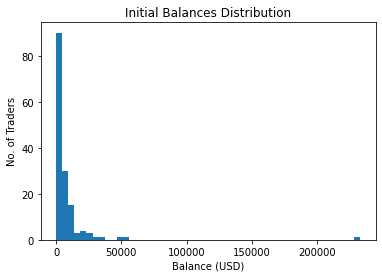

In [103]:
#PLOTTING INITIAL BALANCE FOR AGENTS
plt.hist([agent.bankroll for agent in agents], bins=50)
plt.title('Initial Balances Distribution')
plt.xlabel('Balance (USD)')
plt.ylabel('No. of Traders')
plt.show()

**SIMULATING THE BEHAVIOUR**

In [104]:
# SIMULATING THE BEHAVIOUR : PER BLOCK BASIS
# 1. We store the current value of State Variables
# 2. Loop over the agents, siulating their behaviour 
for i in range(int(BLOCKS_PER_YEAR * SIMULATION_LENGTH_YEARS)):
  # if (i<100):
  #   print('lent_currency' + str(i) + ' = ' + str(lent_currency))
  lent_currency_history.append(lent_currency)

  # if (i<100):
  #   print('borrowed_currency' + str(i) + ' = '  + str(borrowed_currency))
  borrowed_currency_history.append(borrowed_currency)

  # if (i<100):
  #   print('borrow_interest_rate' + str(i) + ' = '  + str(get_borrow_interest_rate()))
  borrow_interest_rate_history.append(get_borrow_interest_rate())

  # if (i<100):
  #   print('supply_interest_rate' + str(i) + ' = ' +  str(get_supply_interest_rate()))
  supply_interest_rate_history.append(get_supply_interest_rate())

  spreadBetweenInterestRatesHistory.append(get_borrow_interest_rate() - get_supply_interest_rate())

  meanEquilibriumInterestRate = np.mean([agent.equilibrium_rate for agent in agents if hasattr(agent, 'equilibrium_rate')])
  # if (i<100):
  #   print('meanEquilibriumInterestRate' + str(i) + ' = ' +  str(meanEquilibriumInterestRate))
  mean_equilibrium_interest_rate_history.append(meanEquilibriumInterestRate)

  mean_Std_equilibriumRate = np.std([agent.equilibrium_rate for agent in agents if hasattr(agent, 'equilibrium_rate')])
  # if (i<100):
  #   print('mean_Std_equilibriumRate' + str(i) + ' = ' +  str(mean_Std_equilibriumRate))
  stdev_equilibrium_interest_rate_history.append(mean_Std_equilibriumRate)

  # if (i<100):
  #   print('Utilization_rate' + str(i) + ' = ' +  str(get_utilization_rate()))
  utilization_rate_history.append(get_utilization_rate())

  interestPaid = borrowed_currency * get_borrow_interest_rate() / BLOCKS_PER_YEAR
  # if (i<100):
  #   print('interestPaid' + str(i) + ' = ' +  str(interestPaid))
  interest_paid_history.append(interestPaid)

  for agent in agents:
    agent.step()


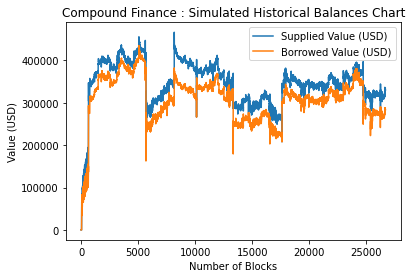

In [105]:
#PLOTTING HISTORICAL CHART OF SUPPLIED / BORROWED BALANCES 
plt.plot(lent_currency_history, label='Supplied Value (USD)')
plt.plot(borrowed_currency_history, label='Borrowed Value (USD)')
plt.title('Compound Finance : Simulated Historical Balances Chart')
plt.xlabel('Number of Blocks')
plt.ylabel('Value (USD)')
plt.legend()
plt.show()

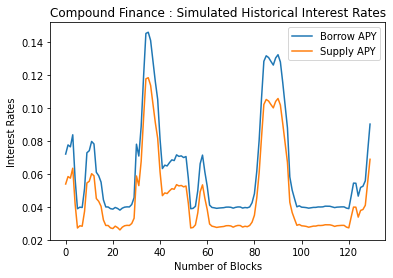

In [106]:
#PLOTTING HISTROICAL INTEREST RATES : SUPPLY APY / BORROW APY 
plt.plot(borrow_interest_rate_history[80:210] , label='Borrow APY')
plt.plot(supply_interest_rate_history[80:210]  , label='Supply APY')
plt.title('Compound Finance : Simulated Historical Interest Rates')
plt.xlabel('Number of Blocks')
plt.ylabel('Interest Rates')
plt.legend()
plt.show()

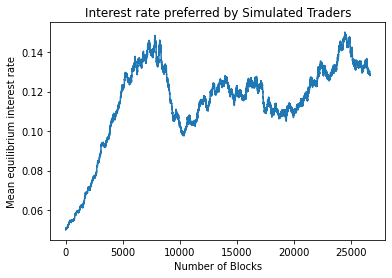

In [107]:
#PLOTTING MEAN EQUILIBRIUM INTEREST RATES FOR TRADERS 
plt.plot(mean_equilibrium_interest_rate_history)
plt.title('Interest rate preferred by Simulated Traders')
plt.xlabel('Number of Blocks')
plt.ylabel('Mean equilibrium interest rate')
plt.show()

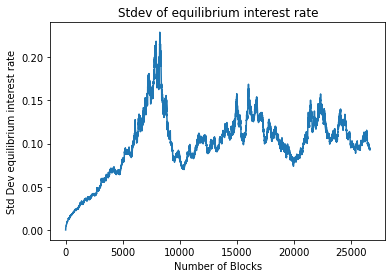

In [108]:
#PLOTTING STD DEV EQUILIBRIUM INTEREST RATES FOR TRADERS 
plt.plot(stdev_equilibrium_interest_rate_history)
plt.title('Stdev of equilibrium interest rate')
plt.xlabel('Number of Blocks')
plt.ylabel('Std Dev equilibrium interest rate')
plt.show()

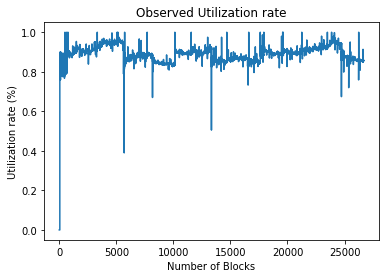

In [109]:
#PLOTTING HISTORICAL UTILIZATION RATES
plt.plot(utilization_rate_history)
plt.title('Observed Utilization rate')
plt.xlabel('Number of Blocks')
plt.ylabel('Utilization rate (%)')
plt.show()

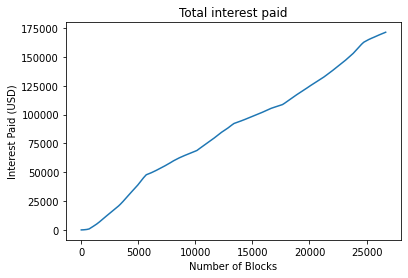

In [110]:
#PLOTTING TOTAL INTEREST PAID
plt.plot(np.cumsum(interest_paid_history))
plt.title('Total interest paid')
plt.xlabel('Number of Blocks')
plt.ylabel('Interest Paid (USD)')
plt.show()

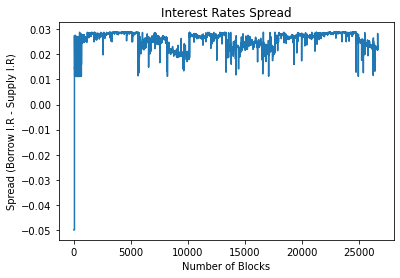

In [111]:
#PLOTTING SPREAD BETWEEN INTEREST RATES
plt.plot(spreadBetweenInterestRatesHistory)
plt.title('Interest Rates Spread')
plt.xlabel('Number of Blocks')
plt.ylabel('Spread (Borrow I.R - Supply I.R)')
plt.show()

##**PID INTEREST RATE MODEL** : SIMULATED PERFORMANCE

**INTITIAL STATE**

In [87]:
interest_rate_model_in_use = 'pid'
block_number = 0

#INITIAL BALANCE
lent_currency = 0
borrowed_currency = 0

# PID RELATED VALUES
pid_derivative_signal = 0
pid_integral_accumulator = 0
pid_last_evaluated_block = 0
pid_last_evaluated_utilization_rate = 0

# VARIABLES WHICH STORE HISTORICAL LIQUIDITY / BORROWING BALANCES AND INTEREST RATES
lent_currency_history = []
borrowed_currency_history = []
borrow_interest_rate_history = []
supply_interest_rate_history = []
mean_equilibrium_interest_rate_history = []
stdev_equilibrium_interest_rate_history = []
utilization_rate_history = []
proportional_signal_history = []
integral_signal_history = []
derivative_signal_history = []
interest_paid_history = []
spreadBetweenInterestRatesHistory = []

agents = []


In [88]:
#INITIALIZING COMMERCIAL TRADERS
for i in range(NUM_COMMERCIAL_TRADERS):
  agents.append(CommercialTrader())

#INITIALIZING NOISE TRADERS
for i in range(NUM_NOISE_TRADERS):
  agents.append(NoiseTrader())

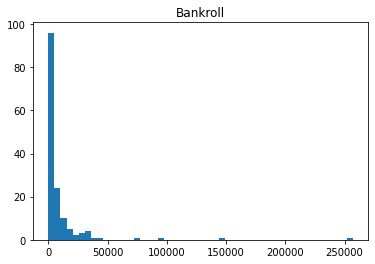

In [89]:
#PLOTTING INITIAL BALANCE FOR AGENTS
plt.hist([agent.bankroll for agent in agents], bins=50)
plt.title('Bankroll')
plt.show()

**SIMULATING BEHAVIOUR**

In [90]:
# SIMULATING THE BEHAVIOUR : PER BLOCK BASIS
# 1. We store the current value of State Variables
# 2. Loop over the agents, siulating their behaviour 
for i in range(int(BLOCKS_PER_YEAR * SIMULATION_LENGTH_YEARS)):
  block_number += 1
  lent_currency_history.append(lent_currency)
  borrowed_currency_history.append(borrowed_currency)
  borrow_interest_rate_history.append(get_borrow_interest_rate())
  supply_interest_rate_history.append(get_supply_interest_rate())
  spreadBetweenInterestRatesHistory.append(get_borrow_interest_rate() - get_supply_interest_rate())
  mean_equilibrium_interest_rate_history.append(np.mean([agent.equilibrium_rate for agent in agents if hasattr(agent, 'equilibrium_rate')]))
  stdev_equilibrium_interest_rate_history.append(np.std([agent.equilibrium_rate for agent in agents if hasattr(agent, 'equilibrium_rate')]))
  utilization_rate_history.append(get_utilization_rate())
  proportional_signal_history.append(get_PID_proportional_signal_pid_irm())
  integral_signal_history.append(pid_integral_accumulator * PID_PID_IRM_INTEGRAL_GAIN)
  derivative_signal_history.append(pid_derivative_signal)
  interest_paid_history.append(borrowed_currency * get_borrow_interest_rate() / BLOCKS_PER_YEAR)

  for agent in agents:
    agent.step()

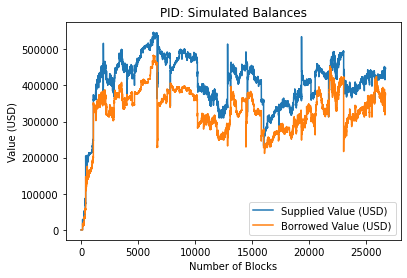

In [91]:
#PLOTTING HISTROICAL CHART OF SUPPLIED / BORROWED BALANCES 
plt.plot(lent_currency_history, label='Supplied Value (USD)')
plt.plot(borrowed_currency_history, label='Borrowed Value (USD)')
plt.title('PID: Simulated Balances')
plt.xlabel('Number of Blocks')
plt.ylabel('Value (USD)')
plt.legend()
plt.show()

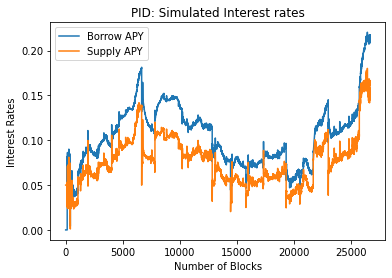

In [92]:
#PLOTTING HISTROICAL INTEREST RATES : SUPPLY APY / BORROW APY 
plt.plot(borrow_interest_rate_history, label='Borrow APY')
plt.plot(supply_interest_rate_history, label='Supply APY')
plt.title('PID: Simulated Interest rates')
plt.xlabel('Number of Blocks')
plt.ylabel('Interest Rates')
plt.legend()
plt.show()

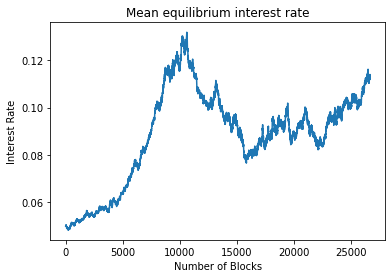

In [93]:
#PLOTTING MEAN EQUILIBRIUM INTEREST RATES FOR TRADERS
plt.plot(mean_equilibrium_interest_rate_history)
plt.title('Mean equilibrium interest rate')
plt.xlabel('Number of Blocks')
plt.ylabel('Interest Rate')
plt.show()

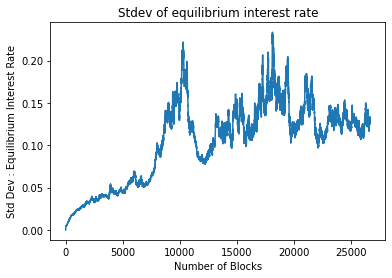

In [94]:
#PLOTTING STD DEV EQUILIBRIUM INTEREST RATES FOR TRADERS 
plt.plot(stdev_equilibrium_interest_rate_history)
plt.title('Stdev of equilibrium interest rate')
plt.xlabel('Number of Blocks')
plt.ylabel('Std Dev : Equilibrium Interest Rate')
plt.show()

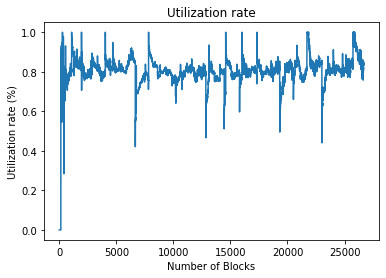

In [95]:
#PLOTTING HISTORICAL UTILIZATION RATES
plt.plot(utilization_rate_history)
plt.title('Utilization rate')
plt.xlabel('Number of Blocks')
plt.ylabel('Utilization rate (%)')
plt.show()

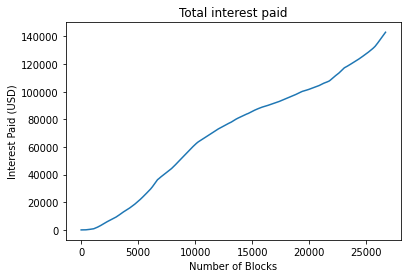

In [96]:
#PLOTTING TOTAL INTEREST PAID
plt.plot(np.cumsum(interest_paid_history))
plt.title('Total interest paid')
plt.xlabel('Number of Blocks')
plt.ylabel('Interest Paid (USD)')
plt.show()


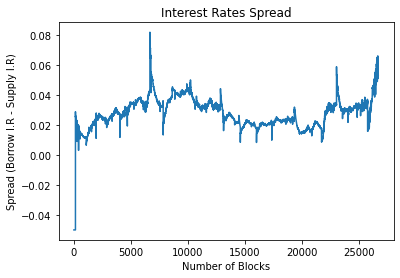

In [97]:
#PLOTTING SPREAD BETWEEN INTEREST RATES
plt.plot(spreadBetweenInterestRatesHistory)
plt.title('Interest Rates Spread')
plt.xlabel('Number of Blocks')
plt.ylabel('Spread (Borrow I.R - Supply I.R)')
plt.show()

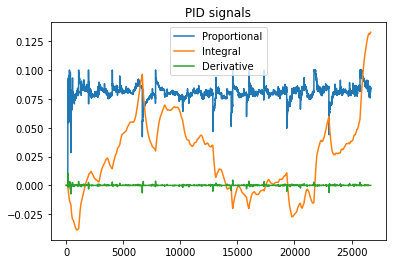

In [98]:
#PLOTTING SIGNALS
plt.plot(proportional_signal_history, label='Proportional')
plt.plot(integral_signal_history, label='Integral')
plt.plot(derivative_signal_history, label='Derivative')
plt.title('PID signals')
plt.legend()
plt.show()

**Compound Finance's Interest Rate Model vs PID-based Model :** 

1. The biggest advantage of a PID-based model is that it allows for low interest rates without needing a correspondingly low utilization rate. Since the utilization rate stays high, the spread between borrowing and lending interest rates is minimized. 
2. A small interest rate spread is important for minimizing deadweight loss. As long as you assume some proportion of traders who will only lend above a certain interest rate and borrow below a certain interest rate, the wider the spread is, the more likely such a trader will be unmotivated to take a position and interact with the market.

Another advantage of such a model is that it simplifies the governance and rate-setting process. 

--> Incentives, such as the addition of COMP emissions to the Compound protocol, can distort markets and make the process of choosing interest rate bounds more complex. For example, a yield-farming protocol might make it more interesting to borrow a stablecoin than it otherwise might have been. 

--> Instead of constantly updating the bounds of an interest rate model in response to DeFi trends, governance updates can be limited to making adjustments to the parameters of the PID controller in response to observed volatility.